In [1]:
import os
import torch
from torch.utils.data import DataLoader
from problems.MCLP.problem_MCLP import MCLP  # Make sure to import from the correct module
from utils import move_to, load_model  # Import the load_model function from utils
import matplotlib.pyplot as plt
import numpy as np
import random
import json
from IPython.display import display, HTML

# Set max-height to 'none' to prevent scrollbar
display(HTML("<style>.output_scroll { height: auto !important; }</style>"))

os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Helper functions

In [2]:
def create_dataset_from_file(file_path):
    # Load parameters from JSON file
    with open(file_path, 'r') as file:
        params = json.load(file)

    # Extract required parameters for make_dataset function
    n_users = params.get('n_users', 500)
    n_facilities = params.get('n_facilities', 150)
    p = params.get('p', 40)
    r = params.get('r', 0.05)

    # Create dataset instance using MCLP.make_dataset
    random_dataset = MCLP.make_dataset(n_users=n_users, n_facilities=n_facilities, num_samples=1, p=p, r=r)

    # Display the dataset instance or process as needed
    print(random_dataset)
    
    return random_dataset


def plot_points(demand_points, demand_vals, candidate_points, selected_idxes, radius, title=None):
    """
    Plot the demand points, candidate points (CLS), and selected coverage circles.

    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (CLS)
    :param selected_idxes: List of indexes corresponding to the selected candidate points
    :param radius: Radius for the coverage circles
    :param demand_vals: Array of demand values corresponding to each demand point
    """
    if len(demand_points) != len(demand_vals):
        raise ValueError("The length of demand_points and demand_vals must be the same.")

    plt.figure(figsize=(10, 8))

    # Normalize demand values for color mapping
    norm = plt.Normalize(vmin=min(demand_vals), vmax=max(demand_vals))
    cmap = plt.cm.Blues

    # Plot demand points with color intensity based on demand values
    plt.scatter(demand_points[:, 0], demand_points[:, 1], c=demand_vals, cmap=cmap, norm=norm, label='Demand Points', s=10)

    # Plot candidate points
    plt.scatter(candidate_points[:, 0], candidate_points[:, 1], c='red', label='Candidate Points (CLS)', s=30, marker='x')

    # Plot selected points and their coverage circles
    for idx in selected_idxes:
        point = candidate_points[idx]
        circle = plt.Circle((point[0], point[1]), radius, color='green', fill=False, linestyle='--',
                            label='Coverage Area' if idx == selected_idxes[0] else "")
        plt.gca().add_patch(circle)
        plt.scatter(point[0], point[1], c='green', label='Selected Points' if idx == selected_idxes[0] else "",
                    s=30, marker='o')

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    if title:
        plt.title(title)
    else:
        plt.title(
            f"{len(demand_points)} demand units - {len(candidate_points)} CLS - {len(selected_idxes)} selected (r={radius})"
        )
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')
    plt.show()
    
    
def calculate_solution_objective(demand_points, demand_vals, facility_candidate_locations, radius, selected_facility_indexes):
    covered_points = set()  

    for facility_idx in selected_facility_indexes:
        facility = facility_candidate_locations[facility_idx]  

        for i, demand_point in enumerate(demand_points):
            distance = np.linalg.norm(facility - demand_point)  
            if distance <= radius:
                covered_points.add(i)  

    total_demand_covered = sum(demand_vals[i] for i in covered_points)
    # Print the number of covered points
    print(f"Number of covered demand points: {len(covered_points)}")

    return total_demand_covered

## Setup dataset

In [3]:
# Set up the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#random_dataset = MCLP.make_dataset(n_users=500, n_facilities=150, num_samples=1, p=40, r=0.05)

# Generate a random dataset
random_dataset = create_dataset_from_file('outputs/MCLP/500_150_40_20241004T203810/args.json')

# Use DataLoader to load the dataset
random_dataloader = DataLoader(random_dataset, batch_size=1)

# get the first batch
batch = next(iter(random_dataloader))
batch = move_to(batch, device)

demand_pts = batch['users'].squeeze(0).cpu().numpy()  # (n_users, 2)
demand_vals = batch['demand'].squeeze(0).cpu().numpy() 
cls = batch['facilities'].squeeze(0).cpu().numpy()  # (n_facilities, 2)
r = 0.05

## DRL model approach

  [*] Loading model from outputs/MCLP/500_150_40_20241004T203810/epoch-199.pt
objective val: 797.9404907226562
log-likelihood: -93.66399383544922
selected facility indexes: [[128, 31, 1, 76, 65, 18, 44, 114, 118, 51, 123, 119, 56, 45, 105, 94, 0, 125, 52, 141, 90, 86, 87, 133, 79, 137, 126, 93, 140, 127, 5, 147, 34, 36, 131, 96, 15, 149, 63, 145]]
Number of covered demand points: 152
[797.9407]


C:\Users\yzhon\AppData\Local\Temp\ipykernel_20308\4078016083.py:66: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


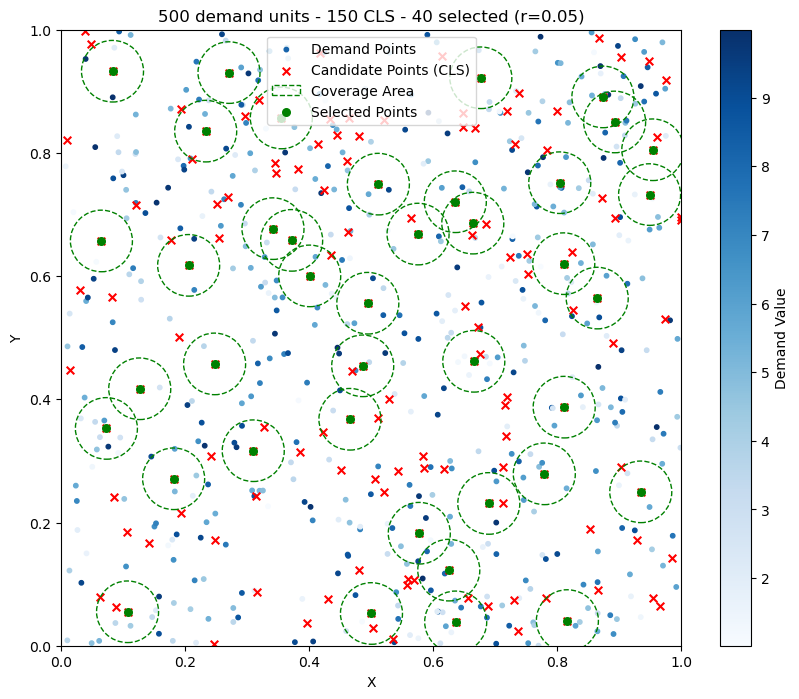

In [4]:
# Load the model using utils.load_model
model_path = 'outputs/MCLP/500_150_40_20241004T203810/epoch-199.pt'  # Adjust this path to your saved model
model, opts = load_model(model_path)  # load_model returns the model and options used during training

model.to(device)  # Move the model to the device (GPU/CPU)
model.eval()  # Set the model to evaluation mode
model.set_decode_type("greedy")
    
with torch.no_grad():
    cost, ll, selected_facilities = model(batch, return_pi=True)
    print("objective val:", -cost.item())
    print("log-likelihood:", ll.item())
    print("selected facility indexes:", selected_facilities.tolist()) 

selected_indices = selected_facilities.squeeze(0).cpu().numpy()  # selected

obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, selected_indices)
print(obj_val)

plot_points(demand_pts, demand_vals, cls, selected_indices, r)

## Heuristic - GA approach

In [ ]:
def generate_population(population_size, num_facilities, max_num_selection):
    """
    Generates the initial population where each solution selects exactly max_num_selection facilities.
    """
    population = []
    for _ in range(population_size):
        solution = random.sample(range(num_facilities), max_num_selection)  # Select max_num_selection facilities
        population.append(solution)
    return population

def calculate_coverage(demand_points, demand_vals, facilities, radius):
    """
    Calculate which demand points are covered by each facility.
    Returns a list where each facility's coverage is a set of demand points it covers.
    """
    coverage_list = []
    for facility in facilities:
        covered_points = set()
        for i, demand_point in enumerate(demand_points):
            if np.linalg.norm(np.array(facility) - np.array(demand_point)) <= radius:
                covered_points.add(i)
        coverage_list.append(covered_points)
    return coverage_list

def fitness(solution, coverage_list, demand_vals):
    """
    Calculates the fitness of a solution based on the total demand covered.
    Ensures that each demand point's value is counted only once, even if it is covered by multiple facilities.
    """
    covered_points = set()
    for facility_idx in solution:
        covered_points.update(coverage_list[facility_idx])
    
    # Calculate the total demand covered, ensuring no double counting
    total_demand_covered = sum(demand_vals[i] for i in covered_points)
    return total_demand_covered

def select_parents(population, fitness_values):
    """
    Selects two parents from the population using roulette wheel selection based on fitness.
    """
    total_fitness = sum(fitness_values)
    normalized_fitness = [fitness / total_fitness for fitness in fitness_values]
    
    def select_one():
        rand = random.random()
        for i, fitness in enumerate(normalized_fitness):
            rand -= fitness
            if rand <= 0:
                return population[i]
    
    return select_one(), select_one()

def crossover(parent1, parent2, max_num_selection):
    """
    Performs crossover between two parents and generates two children.
    Ensures each child has exactly max_num_selection facilities.
    """
    if len(parent1) <= 1 or len(parent2) <= 1:
        return parent1, parent2  # No crossover if one of the parents has only one element
    
    crossover_point = random.randint(1, min(len(parent1), len(parent2)) - 1)
    child1 = list(set(parent1[:crossover_point] + parent2[crossover_point:]))
    child2 = list(set(parent2[:crossover_point] + parent1[crossover_point:]))

    # Ensure each child has exactly max_num_selection facilities
    if len(child1) > max_num_selection:
        child1 = random.sample(child1, max_num_selection)
    elif len(child1) < max_num_selection:
        additional_facilities = [f for f in range(max_num_selection) if f not in child1]
        child1 += random.sample(additional_facilities, max_num_selection - len(child1))
    
    if len(child2) > max_num_selection:
        child2 = random.sample(child2, max_num_selection)
    elif len(child2) < max_num_selection:
        additional_facilities = [f for f in range(max_num_selection) if f not in child2]
        child2 += random.sample(additional_facilities, max_num_selection - len(child2))
    
    return child1, child2

def mutation(child, num_facilities, mutation_rate):
    """
    Mutates a child by swapping one facility with another randomly if mutation occurs.
    """
    if random.random() < mutation_rate and len(child) > 0:
        i = random.randint(0, len(child) - 1)
        new_facility = random.choice([f for f in range(num_facilities) if f not in child])
        child[i] = new_facility
    return child

def solve_mclp_ga(demand_points, demand_vals, facility_candidate_locations, radius, max_num_selection, 
                  population_size=100, max_generations=50, mutation_rate=0.1):
    """
    Solves the MCLP using a genetic algorithm.
    """
    num_facilities = len(facility_candidate_locations)
    coverage_list = calculate_coverage(demand_points, demand_vals, facility_candidate_locations, radius)

    # Generate the initial population
    population = generate_population(population_size, num_facilities, max_num_selection)

    best_solution = None
    best_fitness_value = -float('inf')

    # Run the genetic algorithm over multiple generations
    for generation in range(max_generations):
        fitness_values = [fitness(solution, coverage_list, demand_vals) for solution in population]

        # Find the best solution in this generation
        generation_best_solution = population[fitness_values.index(max(fitness_values))]
        generation_best_fitness = max(fitness_values)

        # Update the global best solution
        if generation_best_fitness > best_fitness_value:
            best_solution = generation_best_solution
            best_fitness_value = generation_best_fitness
        
        new_population = [best_solution]  # Keep the best solution

        # Perform crossover and mutation to generate new solutions
        while len(new_population) < population_size:
            parent1, parent2 = select_parents(population, fitness_values)
            child1, child2 = crossover(parent1, parent2, max_num_selection)
            child1 = mutation(child1, num_facilities, mutation_rate)
            child2 = mutation(child2, num_facilities, mutation_rate)
            new_population.append(child1)
            new_population.append(child2)

        population = new_population[:population_size]

        print(f"Generation {generation+1}: Best fitness = {best_fitness_value}")

    # Print the final objective value (total demand covered by the best solution)
    print("Final Objective Value (Total Demand Covered):", best_fitness_value)
    
    return best_solution

In [ ]:
demand_pts = batch['users'].squeeze(0).cpu().numpy()  # (n_users, 2)
demand_vals = batch['demand'].squeeze(0).cpu().numpy()
cls = batch['facilities'].squeeze(0).cpu().numpy()  # (n_facilities, 2)
radius = 0.05
max_num_selection = 40
population_size = 100
max_generations = 100
mutation_rate = 0.1

# Solve the problem using the genetic algorithm
ga_solution = solve_mclp_ga(demand_pts, demand_vals, cls, radius, max_num_selection, population_size, \
                            max_generations, mutation_rate)

print("Selected facility indexes:", ga_solution)

obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, 0.05, ga_solution)
print(obj_val)

plot_points(demand_pts, demand_vals, cls, ga_solution, 0.05)